# Welcome to LASER

We will start specifying some parameters here. Meta parameters controlling the simulation itself and disease parameters for infection dynamics.

The `Bag()` class is just a convenience class to make code cleaner. E.g., `params.ticks` rather than `params["ticks"]`.

In [2]:
from pathlib import Path

import numpy as np


# just a holder of values
class Bag:
    def __init__(self, *bags):
        for bag in bags:
            for key, value in bag.__dict__.items():
                setattr(self, key, value)

    def __plus__(self, other):
        return Bag(self, other)
    
    def __iadd__(self, other):
        for key, value in other.__dict__.items():
            setattr(self, key, value)
        return self

metaparams = Bag()
metaparams.ticks = 365 * 20
metaparams.nodes = 1
metaparams.seed = 20240612
metaparams.output = Path.cwd() / "outputs"

parameters = Bag()
parameters.exp_mean = np.float32(7.0)
parameters.exp_std = np.float32(1.0)
parameters.inf_mean = np.float32(7.0)
parameters.inf_std = np.float32(1.0)
parameters.r_naught = np.float32(14.0)
parameters.seasonality_factor = np.float32(0.1)
parameters.seasonality_offset = np.int32(182.5)

parameters.beta = parameters.r_naught / parameters.inf_mean


-----

## Scenarios

Two scenarios are easily available for modeling: England + Wales (1944-1964 demographics) and Nigeria (2015 population).

The E+W scenario caches just the distances between nodes and builds the node connectivity matrix on the fly from $C(n_i, n_j) = k * \frac {n_i^a * n_j^b} {d_{i,j}^c}$

The Nigeria scenario caches a connectivity matrix from Kurt's work which can be modified by a scaling factor and upper limit on daily "migration".

Each `initialize` function returns the maximum number of agents we need to accomodate (for memory allocation purposes), the demographics over time, the initial distribution of agents in the S/E/I/R states, and the network connectivity matrix.

In [3]:
# England and Wales Scenario
metaparams.scenario = "engwal"

# England and Wales network parameters (we derive connectivity from these and distance)
netparams = Bag()
netparams.a = np.float32(1.0)   # pop1 power
netparams.b = np.float32(1.0)   # pop2 power
netparams.c = np.float32(2.0)   # distance power
netparams.k = np.float32(500.0) # scaling factor
netparams.max_frac = np.float32(0.05) # max fraction of population that can migrate

from tests.scenario_engwal import initialize_engwal
params = Bag(metaparams, parameters, netparams)
max_capacity, demographics, initial, network = initialize_engwal(None, params, params.nodes)    # doesn't need a model, yet

# Nigeria Scenario
# metaparams.scenario = "nigeria"

# Nigeria network parameter(s)
# netparams = Bag()
# netparams.k = np.float32(1.0) # scaling factor
# netparams.max_frac = np.float32(0.05) # max fraction of population that can migrate

# from tests.scenario_nigeria import initialize_nigeria
# params = Bag(metaparams, parameters, netparams)
# max_capacity, demographics, initial, network = initialize_nigeria(None, params, params.nodes)    # doesn't need a model, yet


Initial population:   2,462,500
Total births:         1,111,495
Total immigrations:     649,201
Max capacity:         4,223,196


-----

## Implementation

We default to the CPU based implementation (NumPy + Numba). The alternative, if running locally or otherwise capable hardware, is the Taichi/GPU implementation.

In [4]:
from datetime import datetime

params.prng_seed = datetime.now(tz=None).microsecond

# CPU based implementation
from idmlaser.models import NumbaSpatialSEIR
model = NumbaSpatialSEIR(params)

# GPU based implementation with Taichi
# from idmlaser.models import TaichiSpatialSEIR
# model = TaichiSpatialSEIR(parameters)

model.initialize(max_capacity, demographics, initial, network)

[Taichi] version 1.7.1, llvm 15.0.4, commit 0f143b2f, linux, python 3.10.13


[I 06/13/24 18:58:58.599 2411] [shell.py:_shell_pop_print@23] Graphical python shell detected, using wrapped sys.stdout
[W 06/13/24 18:58:58.869 2411] [cuda_driver.cpp:load_lib@36] libcuda.so lib not found.
[W 06/13/24 18:58:58.870 2411] [opengl_api.cpp:initialize_opengl@205] Can not create OpenGL context
[W 06/13/24 18:58:58.871 2411] [misc.py:adaptive_arch_select@758] Arch=[<Arch.cuda: 3>, <Arch.metal: 4>, <Arch.vulkan: 10>, <Arch.opengl: 5>, <Arch.dx11: 6>, <Arch.dx12: 7>, <Arch.gles: 11>, <Arch.amdgpu: 9>] is not supported, falling back to CPU


[Taichi] Starting on arch=x64
Model parameters: {'exp_mean': 7.0, 'exp_std': 1.0, 'inf_mean': 7.0, 'inf_std': 1.0, 'r_naught': 14.0, 'prng_seed': 995315, 'ticks': 7300, 'nodes': 1, 'seed': 20240612, 'output': PosixPath('/workspaces/laser/outputs'), 'scenario': 'engwal', 'seasonality_factor': 0.1, 'seasonality_offset': 182, 'beta': 2.0, 'a': 1.0, 'b': 1.0, 'c': 2.0, 'k': 500.0, 'max_frac': 0.05}
Initializing model with 1 nodes: (initial population: 2,462,500 maximum capacity: 4,223,196)


-----

## Running

We run the model for the fully specified number of ticks. Nothing prevents us from running the model for a shorter period of time, inspecting (and possibly modifying) state, and then continuing on with a subsequent `run()` call.

In [5]:
model.run(params.ticks)

100%|██████████| 7300/7300 [02:24<00:00, 50.38it/s]

elapsed time: 0:02:24.914150


-----

### Save results (optional)

The `finalize()` function currently merely writes the parameters used and the results (`model.report`) to disk.

In [6]:
paramfile, npyfile = model.finalize()

Wrote parameters to '/workspaces/laser/outputs/20240613-190301-engwal-parameters.json'.
Wrote SEIR channels, by node, to '/workspaces/laser/outputs/20240613-190301-engwal-1-7300-spatial_seir.npy'.


-----

## SEIR Channels

Let's plot the SEIR values for a node over the duration of the simulation. For single node simulations without any import pressure, we may have had burnout.

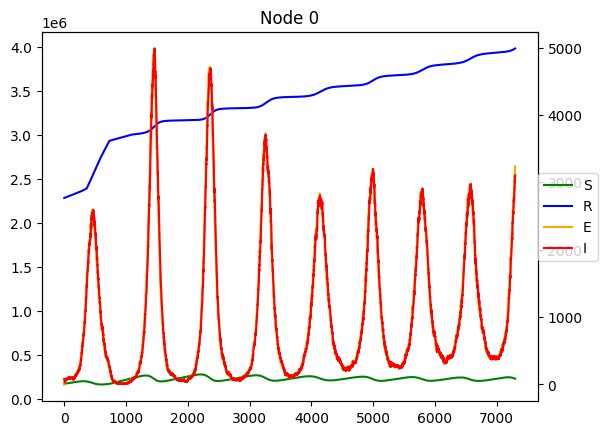

In [10]:
node = 0

# model.report is a 3D numpy array with shape (ticks, compartments, nodes)
S = model.report[:, 0, node]
E = model.report[:, 1, node]
I = model.report[:, 2, node]
R = model.report[:, 3, node]

# alternatively, we could load existing data from disk and plot
# saved = np.load(Path('/workspaces/laser/outputs/20240613-190301-engwal-1-7300-spatial_seir.npy'))   # or np.load(npyfile)
# S = saved[:, 0, node]
# E = saved[:, 1, node]
# I = saved[:, 2, node]
# R = saved[:, 3, node]

import matplotlib.pyplot as plt
fig, ax1 = plt.subplots()
plt.plot(S, label='S', color="green")
plt.plot(R, label='R', color="blue")
ax2 = ax1.twinx()
# ax2.set_yscale("log")
plt.plot(E, label='E', color="orange")
plt.plot(I, label='I', color="red")
plt.title(f"Node {node}")
fig.legend(loc="center right")
plt.show()


-----

## I fraction vs. S fraction Over Time

Let's plot I vs. S over time to see if we approach or reach an equilibrium. Color represents time: dark blue at the start of the simulation, dark red at the end.

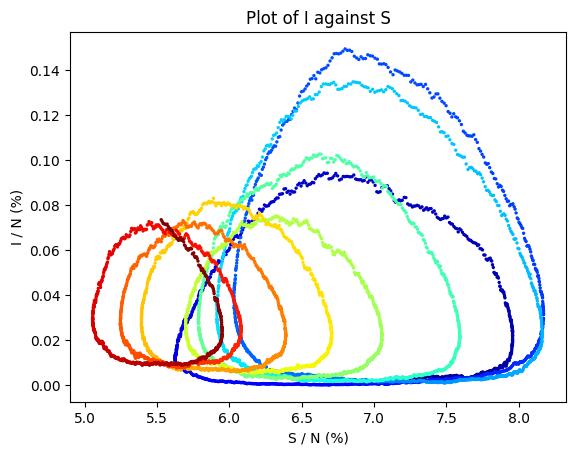

In [8]:
import matplotlib.pyplot as plt
from matplotlib import cm

colors = cm.jet(np.linspace(0, 1, params.ticks+1))  # +1 for initial state
N = (S + E + I + R) / 100.0
# N = 1
plt.scatter(S/N, I/N, s=2, color=colors)
plt.xlabel('S / N (%)')
plt.ylabel('I / N (%)')
plt.title('Plot of I against S')
plt.show()